In [1]:
# https://towardsdatascience.com/how-to-program-umap-from-scratch-e6eff67f55fe

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize
from sklearn.manifold import SpectralEmbedding

expr = pd.read_csv('static/CAFs.txt', sep='\t')

In [3]:
X_train = expr.values[:, :-1]
X_train = np.log(X_train+1)
n = X_train.shape[0]
print("This dataset contains {0} samples".format(n))
Y_train = expr.values[:, -1:]
print("\nDimensions of the data points: {0}, labels: {1}".format(X_train.shape, Y_train.shape))

This dataset contains 716 samples

Dimensions of the data points: (716, 557), labels: (716, 1)


In [4]:
# Matrix of the squared Euclidean distances
dist = np.square(euclidean_distances(X_train, X_train))

In [5]:
#Get the squared Euclidean distance to the nearest neighbor
rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]

In [6]:
print(dist[0:4, 0:4])
print()
print(rho[0:4])

[[   0.          914.95016311 1477.46836099 3036.91172176]
 [ 914.95016311    0.         1307.39294642 2960.41559961]
 [1477.46836099 1307.39294642    0.         2678.34442573]
 [3036.91172176 2960.41559961 2678.34442573    0.        ]]

[805.2464562222542, 652.4022952321459, 1036.9011547563534, 1244.8783774968015]


In [7]:
def prob_high_dim(sigma, row_index):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist[row_index] - rho[row_index]; d[d < 0] = 0
    return np.exp(-d/sigma)

In [8]:
def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))

In [9]:
def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0; sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

N_NEIGHBOR = 15
prob = np.zeros((n,n)); sigma_array = []
for row_index in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, row_index))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[row_index] = prob_high_dim(binary_search_result, row_index)
    sigma_array.append(binary_search_result)
    if (row_index + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(row_index + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

Sigma binary search finished 100 of 716 cells
Sigma binary search finished 200 of 716 cells
Sigma binary search finished 300 of 716 cells
Sigma binary search finished 400 of 716 cells
Sigma binary search finished 500 of 716 cells
Sigma binary search finished 600 of 716 cells
Sigma binary search finished 700 of 716 cells

Mean sigma = 63.51506110676174


In [24]:
#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
P = (prob + np.transpose(prob)) / 2

In [12]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1/(1 + a*x**(2*b))

p, _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1]

print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 1.1214363425627392 and b = 1.0574998764478827


In [44]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances

In [45]:
def CE(P, Y):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y)) ** b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact = np.expand_dims(a*P*(1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

Running Gradient Descent: 

Cross-Entropy = 23.089279505594295 after 0 iterations
Cross-Entropy = 1.5117040013500251 after 10 iterations
Cross-Entropy = 1.1268373567734 after 20 iterations
Cross-Entropy = 1.0074004005377262 after 30 iterations
Cross-Entropy = 0.9457423175625734 after 40 iterations
Cross-Entropy = 0.9587321808288445 after 50 iterations
Cross-Entropy = 0.9420900223621326 after 60 iterations
Cross-Entropy = 0.9387998383125258 after 70 iterations
Cross-Entropy = 0.9726105027633789 after 80 iterations
Cross-Entropy = 0.9538310123243635 after 90 iterations
Cross-Entropy = 1.0263029690917467 after 100 iterations
Cross-Entropy = 1.0245133845532264 after 110 iterations
Cross-Entropy = 1.0427590449991961 after 120 iterations
Cross-Entropy = 0.9534190324177405 after 130 iterations
Cross-Entropy = 1.034951167893119 after 140 iterations
Cross-Entropy = 0.9781061462035513 after 150 iterations
Cross-Entropy = 0.990640100779729 after 160 iterations
Cross-Entropy = 0.9678656343474521 a

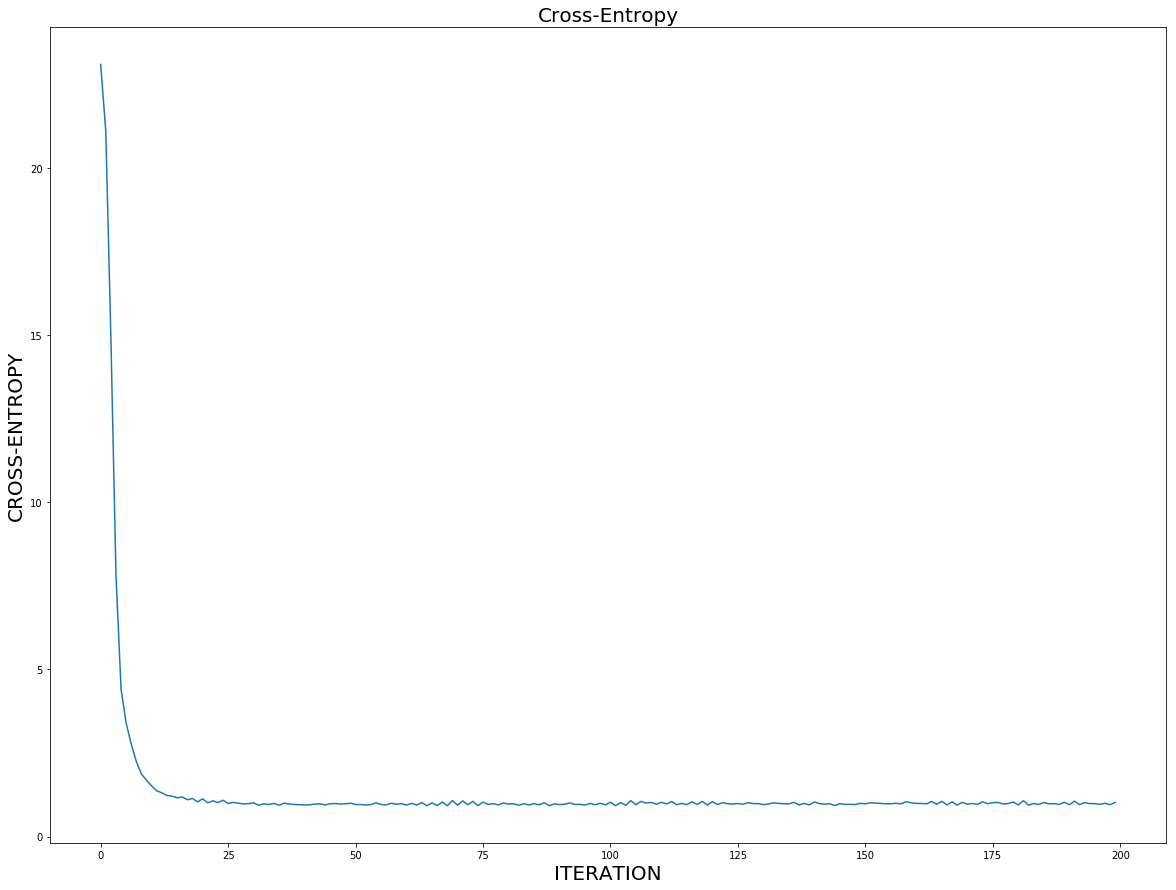

In [46]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 200

np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
c_y = Y_train.astype(int)
c_y = [elem for sub in c_y for elem in sub]

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20, 15))
    plt.scatter(y[:, 0], y[:, 1], c = c_y, cmap = 'tab10', s = 50)
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    plt.savefig('UMAP_Plots/UMAP_iter_' + str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")

plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

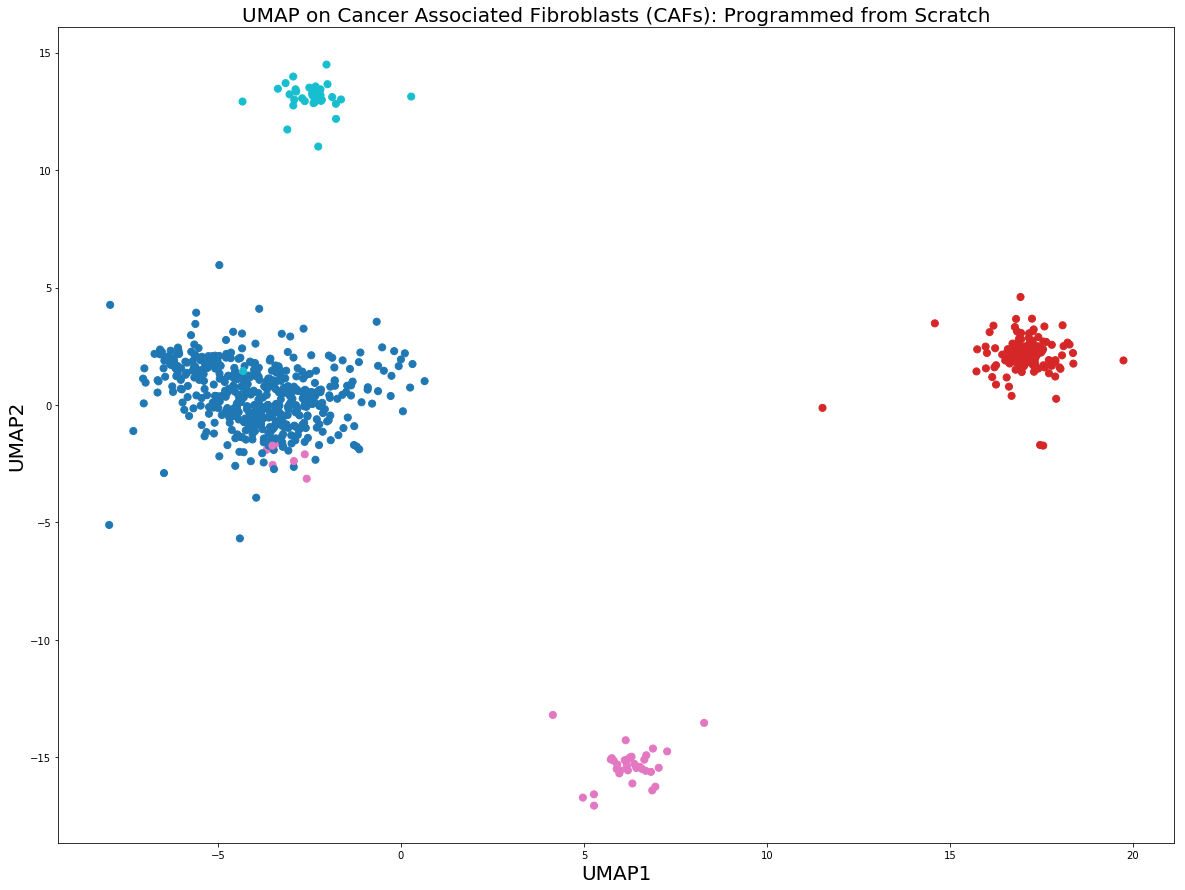

In [47]:
plt.figure(figsize=(20,15))
plt.scatter(y[:, 0], y[:, 1], c=c_y, cmap = 'tab10', s=50)
plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", 
          fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()

In [48]:
#Animation
#convert -delay 0 $(for i in $(seq 0 1 20; seq 21 10 199); do echo UMAP_iter_${i}.png; done) \
#-loop 0 UMAP_animated.gif

SyntaxError: invalid syntax (<ipython-input-48-aa8e91d72025>, line 1)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.25, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


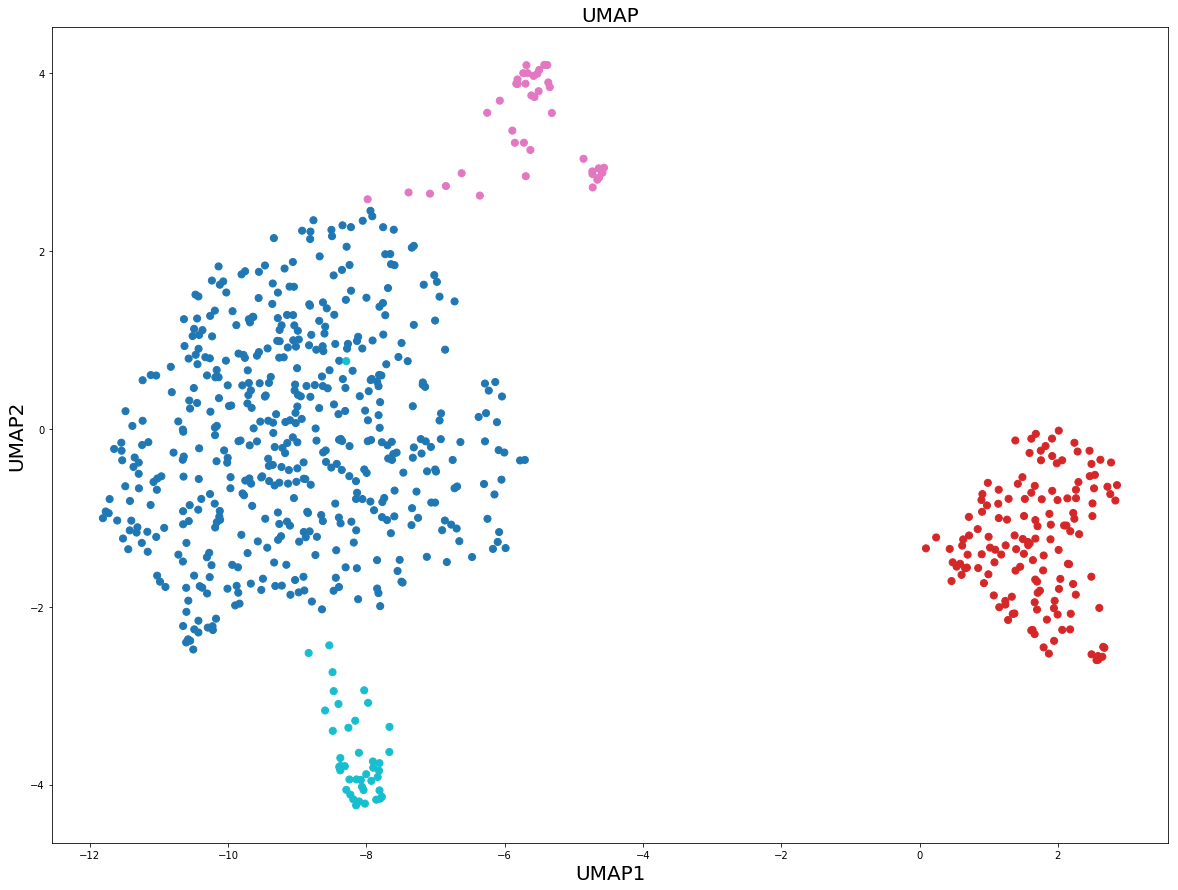

In [50]:
from umap import UMAP
plt.figure(figsize=(20,15))
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(X_train)
plt.scatter(umap[:, 0], umap[:, 1], c = c_y, cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()